# Install

In [ ]:
!pip install fredapi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import


In [ ]:
import requests
import sys
import json
import pandas as pd
import numpy as np
import fredapi as fa

from datetime import datetime
from datetime import timedelta

import tensorflow as tf
from pickle import load

# Constants
Tweakable constants

In [ ]:
#BACKWARD_LOOKING_NUM = 3
BACKWARD_LOOKING_NUM = 30

# Percentage
TREND_FLAT_THREHOLD = 0.05

# Trading fee = 5 USD
FEE_TRADING = 5

In [ ]:
FOURIER_COMPONENTS =[3,6,9,10,11,12]

In [ ]:
#MODEL_FILE = 'WGAN_GP_AAPL_20220908.h5'
#MODEL_FILE = 'WGAN_GP_3_AAPL_20220912.h5'
MODEL_FILE = 'WGAN_GP_3_AAPL_20220918.h5'
X_SCALE_PKL = 'X_scaler.pkl'
Y_SCALE_PKL = 'y_scaler.pkl'

In [ ]:
EPIC_APPLE = 'AAPL'
EPIC_TESLA = 'TSLA'
EPIC_META = 'META'
EPIC_GOOGLE = 'GOOG'
EPIC_NETFLIX = 'NFLX'
EPIC_AMAZON = 'AMZN'

EPIC_SNP500 = 'US500'
EPIC_NASDAQ100 = 'US100'
EPIC_DJIA = 'US30'
EPIC_NASDAQ = 'NDAQ'
EPIC_NIKKEI225 = 'J225'
EPIC_DAX = 'DE40'
EPIC_NIFTY50 = 'NIFTY50'
EPIC_HSI = 'HK50'

EPIC_GOLD = 'GOLD'
EPIC_SILVER = 'SILVER'
EPIC_CRUDE_OIL = 'OIL_CRUDE'
EPIC_BRENT_OIL = 'OIL_BRENT'
EPIC_NATURAL_GAS = 'NATURALGAS'

FRED_10_YR_TREASURY_CONST_MATURITY_MINUS_2_YR = 'T10Y2Y'
FRED_10_YR_BREAKEVEN_INFLATION_RATE = 'T10YIE'
FRED_5_YR_BREAKEVEN_INFLATION_RATE = 'T5YIE'
FRED_5_YR_FORWARD_EXPECTED_INFLATION_RATE = 'T5YIFR'

In [ ]:
STOCK_INTEREST = EPIC_APPLE

STOCK_LIST = [
   EPIC_APPLE,
   EPIC_TESLA,
   EPIC_META,
   EPIC_GOOGLE,
   EPIC_NETFLIX,
   EPIC_AMAZON,
   EPIC_SNP500,
   EPIC_NASDAQ100,
   #EPIC_DJIA,
   #EPIC_NASDAQ,
   #EPIC_NIKKEI225,
   #EPIC_DAX,
   #EPIC_NIFTY50,
   #EPIC_HSI,
   EPIC_GOLD,
   EPIC_SILVER,
   EPIC_CRUDE_OIL,
   #EPIC_BRENT_OIL,
   EPIC_NATURAL_GAS,
]

FRED_LIST = [
    FRED_10_YR_TREASURY_CONST_MATURITY_MINUS_2_YR,
    #FRED_10_YR_BREAKEVEN_INFLATION_RATE,
    #FRED_5_YR_BREAKEVEN_INFLATION_RATE,
    FRED_5_YR_FORWARD_EXPECTED_INFLATION_RATE,
]

In [ ]:
QUERY_NUM = 1000
QUERY_INTERVAL = 'DAY'

Not Tweakable

In [ ]:
DATE_FORMAT = '%Y-%m-%dT%H:%M:%S'
DATE_DF_FORMAT = '%Y-%m-%d'

Capital.com API Constant

In [ ]:
API_KEY = '<ENTER_API_KEY>'
API_LOGIN = '<ENTER_LOGIN>'
API_PASS = '<ENTER_PASSWORD>'

API_ENDPOINT = 'https://demo-api-capital.backend-capital.com'
API_PREFIX = '/api/v1'
API_BASE_URL = API_ENDPOINT + API_PREFIX

In [ ]:
API_CONTENT_TYPE_KEY = 'Content-Type'
API_CONTENT_TYPE_VALUE = 'application/json'

FRED API Constant

In [ ]:
fred = fa.Fred(api_key='6ffa4ce000638cd6532d02bfb42fedc7')

# API Path

In [ ]:
PATH_API_SESSION = '/session'
PATH_API_MARKET = '/market'
PATH_API_PRICES = '/prices'
PATH_API_WATCHLISTS = '/watchlists'
PATH_API_POSITIONS = '/positions'

# Helper Function
Hardcode for testing

In [ ]:
def GetYesterdayDate():
  return datetime.today() - timedelta(days=1)

In [ ]:
def GetDateList(date_time_from, date_time_to):
  date_list = []
  while date_time_from <= date_time_to:
    no = date_time_from.weekday()

    # Only add weekday
    if no < 5:
      date_list.append(date_time_from.strftime(DATE_DF_FORMAT))

    date_time_from = date_time_from + timedelta(days=1)

  return date_list

def ConvertDictOfObjectToDictOfValue(map, field):
  ret = {}
  for key in map:
    ret[key] = map[key][field]
  
  return ret

# Load
Load prediction csv

In [ ]:
#df = pd.read_csv ('test_predicted.csv')
#df.rename( columns={'Unnamed: 0':'Date'}, inplace=True )

Extract into list

In [ ]:
#date_time_start = GetTodayDate()
#date_time_end = GetForwardLookingDate()

In [ ]:
#df['Date'] = pd.to_datetime(df['Date'], format=DATE_FORMAT)

In [ ]:
#rslt_df = df[(df['Date'] >= date_time_start) & (df['Date'] <= date_time_end)]

In [ ]:
#rslt_df.tail()

In [ ]:
#price_list = rslt_df['predicted_mean'].tolist()

# Create Session

In [ ]:
def CreateSession():
  create_session_payload = {
      'identifier': API_LOGIN,
      'password': API_PASS,
  }

  create_session_headers = {
      'X-CAP-API-KEY': API_KEY,
      API_CONTENT_TYPE_KEY: API_CONTENT_TYPE_VALUE,
  }

  create_session_url = API_BASE_URL + PATH_API_SESSION
  result = requests.post(create_session_url,
                        data=json.dumps(create_session_payload),
                        headers=create_session_headers)
  
  return result.headers['CST'], result.headers['X-SECURITY-TOKEN']

In [ ]:
cst, security_token = CreateSession()
api_headers = {
    'CST': cst,
    'X-SECURITY-TOKEN': security_token,
}

#Get Market Price

In [ ]:
def GetMarketPrices(api_headers, stock_interest, stock_list, query_interval, query_num, date_to):
  #date_time_from = datetime.strptime(date_from, DATE_FORMAT)
  #date_time_to = datetime.strptime(date_to, DATE_FORMAT)

  date_time_from = date_to - timedelta(days=query_num - 1)
  date_time_to = date_to

  date_list = GetDateList(date_time_from, date_time_to)
  df = pd.DataFrame({
      'Date': date_list,
  })

  interest_price_map = DoGetStockPrice(stock_interest, query_interval, query_num, date_time_from, date_time_to, ProcessInterestStockPrices)
  AddInterestStockInfoToDatadrame(df, interest_price_map, date_list, 'Open')
  AddInterestStockInfoToDatadrame(df, interest_price_map, date_list, 'High')
  AddInterestStockInfoToDatadrame(df, interest_price_map, date_list, 'Low')
  AddInterestStockInfoToDatadrame(df, interest_price_map, date_list, 'Close')
  AddInterestStockInfoToDatadrame(df, interest_price_map, date_list, 'Volume')

  for epic in stock_list:
    # skip
    if epic == stock_interest:
      continue

    price_map = DoGetStockPrice(epic, query_interval, query_num, date_time_from, date_time_to, ProcessStockPrices)

    series = pd.Series(price_map, index=date_list)
    print(series.tolist())
    df[epic] = series.tolist()

  #return df.dropna(thresh=len(df.columns) - 1)[-backward_num:]
  return df.dropna(thresh=len(df.columns) - 1)

def DoGetStockPrice(epic, query_interval, query_num, date_from, date_to, processor):
  date_time_current_from = date_from
  price_map = {}

  while date_time_current_from < date_to:
    date_time_current = date_time_current_from + timedelta(days=query_num - 1)
    if date_time_current > date_to:
      date_time_current = date_to
      
    api_params = {
      'resolution': query_interval,
      'max': query_num,
      'from': date_time_current_from.strftime(DATE_FORMAT),
      'to': date_time_current.strftime(DATE_FORMAT),
    }

    print("[DoGetStockPrice] " + epic + " | date from: " + api_params['from'] + " - date to: " + api_params['to'])
      
    get_prices_url = API_BASE_URL + PATH_API_PRICES + '/' + epic
    result = requests.get(get_prices_url, api_params, headers=api_headers)
    response = result.json()

    print("[GetMarketPrices] response: ")
    print(json.dumps(response))
  
    processor(response, price_map)

    date_time_current_from = date_time_current
    print("-----------------------------------------------------------------------------------------------------")

  return price_map

def AddInterestStockInfoToDatadrame(df, price_map, date_list, field):
  map = ConvertDictOfObjectToDictOfValue(price_map, field)
  series = pd.Series(map, index=date_list)
  df[field] = series.tolist()

def ProcessStockPrices(response, price_map):
  for price in response['prices']:
    cd = datetime.strptime(price['snapshotTimeUTC'], DATE_FORMAT)
    
    if 'ask' in price['closePrice']:
      price_map[cd.strftime(DATE_DF_FORMAT)] = price['closePrice']['ask']
    else:
      price_map[cd.strftime(DATE_DF_FORMAT)] = price['closePrice']['bid']

def ProcessInterestStockPrices(response, price_map):
  for price in response['prices']:
    cd = datetime.strptime(price['snapshotTimeUTC'], DATE_FORMAT)
    key = cd.strftime(DATE_DF_FORMAT)
    price_map[key] = {}
    if 'ask' in price['openPrice']:
      price_map[key]['Open'] = price['openPrice']['ask']
      price_map[key]['High'] = price['highPrice']['ask']
      price_map[key]['Low'] = price['lowPrice']['ask']
      price_map[key]['Close'] = price['closePrice']['ask']
    else:
      price_map[key]['Open'] = price['openPrice']['bid']
      price_map[key]['High'] = price['highPrice']['bid']
      price_map[key]['Low'] = price['lowPrice']['bid']
      price_map[key]['Close'] = price['closePrice']['bid']

    price_map[key]['Volume'] = price['lastTradedVolume']

Get additional 100 days before. Needed to calculate 21 days moving average

In [ ]:
df = GetMarketPrices(api_headers, STOCK_INTEREST, STOCK_LIST, QUERY_INTERVAL, 100 + BACKWARD_LOOKING_NUM, GetYesterdayDate())

[DoGetStockPrice] AAPL | date from: 2022-05-15T13:42:27 - date to: 2022-09-21T13:42:27
[GetMarketPrices] response: 
{"prices": [{"snapshotTime": "2022-05-16T08:00:00", "snapshotTimeUTC": "2022-05-16T00:00:00", "openPrice": {"bid": 145.59, "ask": 145.69}, "closePrice": {"bid": 145.86, "ask": 146.0}, "highPrice": {"bid": 147.49, "ask": 147.55}, "lowPrice": {"bid": 144.16, "ask": 144.22}, "lastTradedVolume": 202988}, {"snapshotTime": "2022-05-17T08:00:00", "snapshotTimeUTC": "2022-05-17T00:00:00", "openPrice": {"bid": 147.68, "ask": 147.74}, "closePrice": {"bid": 149.18, "ask": 149.25}, "highPrice": {"bid": 149.74, "ask": 149.8}, "lowPrice": {"bid": 146.66, "ask": 146.71}, "lastTradedVolume": 169335}, {"snapshotTime": "2022-05-18T08:00:00", "snapshotTimeUTC": "2022-05-18T00:00:00", "openPrice": {"bid": 148.39, "ask": 148.6}, "closePrice": {"bid": 140.18, "ask": 140.29}, "highPrice": {"bid": 148.76, "ask": 148.81}, "lowPrice": {"bid": 139.94, "ask": 140.0}, "lastTradedVolume": 137609}, {"s

In [ ]:
df

,Date,Open,High,Low,Close,Volume,TSLA,META,GOOG,NFLX,AMZN,US500,US100,GOLD,SILVER,OIL_CRUDE,NATURALGAS
0,2022-05-16,145.69,147.55,144.22,146.00,202988.0,241.64,200.08,114.95,187.51,111.11,4013.8,12272.3,1826.52,21.609,111.79,8.173
1,2022-05-17,147.74,149.80,146.71,149.25,169335.0,254.85,202.51,116.90,190.82,115.46,4089.2,12564.2,1814.69,21.646,110.85,8.423
2,2022-05-18,148.60,148.81,140.00,140.29,137609.0,234.30,190.76,111.75,176.02,106.20,3901.5,11825.5,1816.28,21.353,105.41,8.223
3,2022-05-19,139.50,141.68,136.63,138.41,278027.0,239.62,192.91,111.34,185.12,108.00,3912.5,11934.0,1842.16,21.914,108.72,8.231
4,2022-05-20,139.35,140.51,132.64,137.33,239375.0,220.78,193.50,109.35,186.39,107.75,3905.8,11837.8,1846.92,21.760,109.87,8.169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2022-09-15,155.77,155.77,151.17,151.41,140943.0,300.32,148.11,103.55,232.54,123.93,3879.8,11846.8,1662.47,18.978,84.24,8.302
89,2022-09-16,151.13,151.58,148.39,150.98,159521.0,303.40,146.60,104.25,240.69,123.85,3887.6,11892.2,1675.60,19.588,84.99,7.864
90,2022-09-19,149.60,155.02,148.73,155.02,174953.0,309.53,148.52,104.82,244.50,125.49,3917.2,12012.2,1675.96,19.549,85.39,7.950
91,2022-09-20,153.88,158.11,153.13,156.51,193568.0,307.51,146.07,102.38,243.30,122.18,3861.7,11860.4,1666.58,19.303,83.96,7.815


# Get FRED Data

In [ ]:
def AppendFREDData(fred_list, df):
  df_date_list = df['Date'].tolist()

  for symbol in fred_list:
    item = fred.get_series(symbol)

    add = item[[i.strftime(DATE_DF_FORMAT) in df_date_list for i in item.index]]
    df[symbol] = add.tolist()

  return df

In [ ]:
df = AppendFREDData(FRED_LIST, df)

In [ ]:
item = fred.get_series(FRED_LIST[0])

In [ ]:
item.tail()

2022-09-15   -0.42
2022-09-16   -0.40
2022-09-19   -0.46
2022-09-20   -0.39
2022-09-21   -0.51
dtype: float64

In [ ]:
df.tail()

,Date,Open,High,Low,Close,Volume,TSLA,META,GOOG,NFLX,AMZN,US500,US100,GOLD,SILVER,OIL_CRUDE,NATURALGAS,T10Y2Y,T5YIFR
88,2022-09-15,155.77,155.77,151.17,151.41,140943.0,300.32,148.11,103.55,232.54,123.93,3879.8,11846.8,1662.47,18.978,84.24,8.302,-0.42,2.29
89,2022-09-16,151.13,151.58,148.39,150.98,159521.0,303.40,146.60,104.25,240.69,123.85,3887.6,11892.2,1675.60,19.588,84.99,7.864,-0.40,2.27
90,2022-09-19,149.60,155.02,148.73,155.02,174953.0,309.53,148.52,104.82,244.50,125.49,3917.2,12012.2,1675.96,19.549,85.39,7.950,-0.46,2.24
91,2022-09-20,153.88,158.11,153.13,156.51,193568.0,307.51,146.07,102.38,243.30,122.18,3861.7,11860.4,1666.58,19.303,83.96,7.815,-0.39,2.32
92,2022-09-21,156.48,158.73,152.25,152.49,296918.0,299.33,140.86,99.71,234.94,117.35,3767.7,11545.7,1667.23,19.473,82.77,7.799,-0.51,2.29


# Fourier Transform Data

In [ ]:
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
def get_fourier_transfer(dataset, components):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in components:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [ ]:
df.iloc[:,4]

0     146.00
1     149.25
2     140.29
3     138.41
4     137.33
       ...  
88    151.41
89    150.98
90    155.02
91    156.51
92    152.49
Name: Close, Length: 89, dtype: float64

Calculate technical indicators

In [ ]:
T_df = get_technical_indicators(df)

In [ ]:
T_df

,Date,Open,High,Low,Close,Volume,TSLA,META,GOOG,NFLX,...,T10Y2Y,T5YIFR,MA7,MA21,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2022-05-16,145.69,147.55,144.22,146.00,202988.0,241.64,200.08,114.95,187.51,...,0.30,2.32,NaN,NaN,0.310000,NaN,NaN,NaN,146.000000,4.976734
1,2022-05-17,147.74,149.80,146.71,149.25,169335.0,254.85,202.51,116.90,190.82,...,0.27,2.34,NaN,NaN,1.682115,NaN,NaN,NaN,148.437500,4.998900
2,2022-05-18,148.60,148.81,140.00,140.29,137609.0,234.30,190.76,111.75,176.02,...,0.21,2.39,NaN,NaN,-1.374906,NaN,NaN,NaN,142.796923,4.936558
3,2022-05-19,139.50,141.68,136.63,138.41,278027.0,239.62,192.91,111.34,185.12,...,0.21,2.21,NaN,NaN,-2.163232,NaN,NaN,NaN,139.835750,4.922969
4,2022-05-20,139.35,140.51,132.64,137.33,239375.0,220.78,193.50,109.35,186.39,...,0.18,2.22,NaN,NaN,-2.597764,NaN,NaN,NaN,138.158347,4.915078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2022-09-15,155.77,155.77,151.17,151.41,140943.0,300.32,148.11,103.55,232.54,...,-0.42,2.29,156.310000,161.709524,0.668821,6.684972,175.079468,148.339580,153.028229,5.013365
89,2022-09-16,151.13,151.58,148.39,150.98,159521.0,303.40,146.60,104.25,240.69,...,-0.40,2.27,155.585714,160.637143,1.225470,6.304904,173.246951,148.027335,151.662743,5.010502
90,2022-09-19,149.60,155.02,148.73,155.02,174953.0,309.53,148.52,104.82,244.50,...,-0.46,2.24,155.637143,159.726190,2.180921,5.793128,171.312446,148.139935,153.900914,5.037082
91,2022-09-20,153.88,158.11,153.13,156.51,193568.0,307.51,146.07,102.38,243.30,...,-0.39,2.32,155.491429,159.021429,2.418437,5.427141,169.875711,148.167146,155.640305,5.046710


Drop first 21 rows (because moving average will be invalid)

In [ ]:
dataset = T_df.iloc[20:,:].reset_index(drop=True)

Get Fourier transform features

In [ ]:
dataset_F = get_fourier_transfer(dataset, FOURIER_COMPONENTS)
Final_data = pd.concat([dataset, dataset_F], axis=1)

In [ ]:
Final_data.head()

,Date,Open,High,Low,Close,Volume,TSLA,META,GOOG,NFLX,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
0,2022-06-14,133.60,133.91,131.54,133.89,102230.0,223.13,166.00,108.42,169.54,...,154.711578,132.229374,134.226187,4.889522,143.340052,-0.010579,141.074785,-0.004039,141.474202,-0.003889
1,2022-06-15,133.63,137.34,132.20,136.51,111857.0,235.53,172.20,111.74,182.69,...,154.294336,131.742807,135.748729,4.909045,141.938521,-0.010760,138.117058,-0.002592,136.054925,-0.004245
2,2022-06-16,132.49,133.50,129.11,130.71,103830.0,211.67,161.66,107.17,175.04,...,154.595552,129.675876,132.389576,4.865301,140.659814,-0.010130,135.940230,-0.000309,132.305071,-0.001800
3,2022-06-17,131.40,133.11,129.85,131.56,104673.0,216.68,162.56,108.09,175.94,...,154.973074,128.466926,131.836525,4.871833,139.542340,-0.008721,134.688317,0.002126,131.183519,0.001924
4,2022-06-21,134.50,137.08,133.26,135.89,68074.0,237.53,157.21,112.12,171.39,...,154.972388,128.227612,134.538842,4.904460,138.620294,-0.006627,134.357824,0.003954,132.660448,0.004393


In [ ]:
df = Final_data[-BACKWARD_LOOKING_NUM:]

In [ ]:
df

,Date,Open,High,Low,Close,Volume,TSLA,META,GOOG,NFLX,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
39,2022-08-10,164.80,169.33,164.70,169.21,103488.0,293.32,178.35,120.98,245.55,...,171.067664,144.092336,167.851432,5.125213,169.720800,0.004374,168.697395,0.003548,167.863593,-0.003656
40,2022-08-11,169.31,171.02,168.24,168.82,119652.0,288.24,177.70,120.46,243.55,...,172.338833,145.141167,168.497144,5.122892,170.331250,0.002065,169.917898,0.003521,169.997911,-0.002250
41,2022-08-12,169.39,172.18,168.73,172.10,83724.0,300.02,180.50,122.92,249.42,...,173.863322,145.782392,170.899048,5.142248,170.722486,-0.000380,171.066865,0.002478,172.055931,0.000532
42,2022-08-15,171.34,173.42,170.76,173.19,61205.0,309.68,180.77,123.23,249.00,...,174.609807,147.239717,172.426349,5.148599,170.887997,-0.002789,172.025206,0.000732,173.516054,0.002925
43,2022-08-16,172.83,174.11,171.69,173.84,85216.0,306.64,179.54,122.85,245.69,...,176.107112,148.302411,173.368783,5.152366,170.830052,-0.004994,172.679273,-0.001208,174.021398,0.003455
44,2022-08-17,173.01,176.17,172.20,173.50,139823.0,303.17,174.26,120.38,239.90,...,177.094698,149.381492,173.456261,5.150397,170.559405,-0.006838,172.939401,-0.002789,173.530945,0.001805
45,2022-08-18,173.53,174.92,173.15,174.15,91197.0,303.34,174.60,121.25,245.53,...,178.188477,150.330571,173.918754,5.154158,170.094471,-0.008189,172.752081,-0.003564,172.332672,-0.001007
46,2022-08-19,172.90,173.75,171.26,171.31,83584.0,296.69,167.95,118.56,241.20,...,178.361807,151.725812,172.179585,5.137620,169.460020,-0.008948,172.104212,-0.003311,170.895641,-0.003220
47,2022-08-22,169.50,169.89,167.16,168.00,99529.0,290.54,163.73,116.00,227.04,...,177.573014,153.815557,169.393195,5.117994,168.685444,-0.009054,171.020063,-0.002093,169.628727,-0.003405
48,2022-08-23,168.15,168.73,166.68,167.23,122531.0,296.67,161.07,115.15,224.65,...,176.418724,156.355562,167.951065,5.113372,167.802718,-0.008492,169.553567,-0.000248,168.669266,-0.001412


In [ ]:
# Check NA and fill them
dataset = df
dataset.isnull().sum()
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1851: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [ ]:
dataset

,Date,Open,High,Low,Close,Volume,TSLA,META,GOOG,NFLX,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
39,2022-08-10,164.80,169.33,164.70,169.21,103488.0,293.32,178.35,120.98,245.55,...,171.067664,144.092336,167.851432,5.125213,169.720800,0.004374,168.697395,0.003548,167.863593,-0.003656
40,2022-08-11,169.31,171.02,168.24,168.82,119652.0,288.24,177.70,120.46,243.55,...,172.338833,145.141167,168.497144,5.122892,170.331250,0.002065,169.917898,0.003521,169.997911,-0.002250
41,2022-08-12,169.39,172.18,168.73,172.10,83724.0,300.02,180.50,122.92,249.42,...,173.863322,145.782392,170.899048,5.142248,170.722486,-0.000380,171.066865,0.002478,172.055931,0.000532
42,2022-08-15,171.34,173.42,170.76,173.19,61205.0,309.68,180.77,123.23,249.00,...,174.609807,147.239717,172.426349,5.148599,170.887997,-0.002789,172.025206,0.000732,173.516054,0.002925
43,2022-08-16,172.83,174.11,171.69,173.84,85216.0,306.64,179.54,122.85,245.69,...,176.107112,148.302411,173.368783,5.152366,170.830052,-0.004994,172.679273,-0.001208,174.021398,0.003455
44,2022-08-17,173.01,176.17,172.20,173.50,139823.0,303.17,174.26,120.38,239.90,...,177.094698,149.381492,173.456261,5.150397,170.559405,-0.006838,172.939401,-0.002789,173.530945,0.001805
45,2022-08-18,173.53,174.92,173.15,174.15,91197.0,303.34,174.60,121.25,245.53,...,178.188477,150.330571,173.918754,5.154158,170.094471,-0.008189,172.752081,-0.003564,172.332672,-0.001007
46,2022-08-19,172.90,173.75,171.26,171.31,83584.0,296.69,167.95,118.56,241.20,...,178.361807,151.725812,172.179585,5.137620,169.460020,-0.008948,172.104212,-0.003311,170.895641,-0.003220
47,2022-08-22,169.50,169.89,167.16,168.00,99529.0,290.54,163.73,116.00,227.04,...,177.573014,153.815557,169.393195,5.117994,168.685444,-0.009054,171.020063,-0.002093,169.628727,-0.003405
48,2022-08-23,168.15,168.73,166.68,167.23,122531.0,296.67,161.07,115.15,224.65,...,176.418724,156.355562,167.951065,5.113372,167.802718,-0.008492,169.553567,-0.000248,168.669266,-0.001412


In [ ]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [ ]:
dataset

,Open,High,Low,Close,Volume,TSLA,META,GOOG,NFLX,AMZN,...,upper_band,lower_band,EMA,logmomentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
2022-08-10,164.80,169.33,164.70,169.21,103488.0,293.32,178.35,120.98,245.55,142.77,...,171.067664,144.092336,167.851432,5.125213,169.720800,0.004374,168.697395,0.003548,167.863593,-0.003656
2022-08-11,169.31,171.02,168.24,168.82,119652.0,288.24,177.70,120.46,243.55,141.06,...,172.338833,145.141167,168.497144,5.122892,170.331250,0.002065,169.917898,0.003521,169.997911,-0.002250
2022-08-12,169.39,172.18,168.73,172.10,83724.0,300.02,180.50,122.92,249.42,143.48,...,173.863322,145.782392,170.899048,5.142248,170.722486,-0.000380,171.066865,0.002478,172.055931,0.000532
2022-08-15,171.34,173.42,170.76,173.19,61205.0,309.68,180.77,123.23,249.00,142.96,...,174.609807,147.239717,172.426349,5.148599,170.887997,-0.002789,172.025206,0.000732,173.516054,0.002925
2022-08-16,172.83,174.11,171.69,173.84,85216.0,306.64,179.54,122.85,245.69,144.78,...,176.107112,148.302411,173.368783,5.152366,170.830052,-0.004994,172.679273,-0.001208,174.021398,0.003455
2022-08-17,173.01,176.17,172.20,173.50,139823.0,303.17,174.26,120.38,239.90,141.81,...,177.094698,149.381492,173.456261,5.150397,170.559405,-0.006838,172.939401,-0.002789,173.530945,0.001805
2022-08-18,173.53,174.92,173.15,174.15,91197.0,303.34,174.60,121.25,245.53,142.38,...,178.188477,150.330571,173.918754,5.154158,170.094471,-0.008189,172.752081,-0.003564,172.332672,-0.001007
2022-08-19,172.90,173.75,171.26,171.31,83584.0,296.69,167.95,118.56,241.20,138.03,...,178.361807,151.725812,172.179585,5.137620,169.460020,-0.008948,172.104212,-0.003311,170.895641,-0.003220
2022-08-22,169.50,169.89,167.16,168.00,99529.0,290.54,163.73,116.00,227.04,134.24,...,177.573014,153.815557,169.393195,5.117994,168.685444,-0.009054,171.020063,-0.002093,169.628727,-0.003405
2022-08-23,168.15,168.73,166.68,167.23,122531.0,296.67,161.07,115.15,224.65,133.62,...,176.418724,156.355562,167.951065,5.113372,167.802718,-0.008492,169.553567,-0.000248,168.669266,-0.001412


# Predict Today's Price

In [ ]:
# Load scaler/ index
X_scaler = load(open(X_SCALE_PKL, 'rb'))
y_scaler = load(open(Y_SCALE_PKL, 'rb'))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


Normalise Data

In [ ]:
X_scale_df = X_scaler.transform(dataset)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
X_scale_df

array([[ 0.76657609,  0.80913199,  0.799834  ,  0.82665487, -0.60277478,
         0.41856772, -0.58006428,  0.43479491, -0.61844925,  0.3713878 ,
         0.53758183,  0.43098492,  0.37924261, -0.04153933,  0.41326909,
         0.61041793, -0.97101449,  0.5359116 ,  0.80335026,  0.73661186,
        -0.43801466,  0.46733839,  0.80282927,  0.62382383,  0.82499259,
         0.91272454,  1.06888116, -0.15178326,  0.94309067, -0.14159821,
         1.00050399, -0.37188662],
       [ 0.82785326,  0.83192824,  0.84880343,  0.82134839, -0.54067076,
         0.39295707, -0.58509856,  0.42498821, -0.62571273,  0.34698537,
         0.53892263,  0.41969831,  0.3733942 , -0.07764573,  0.45756116,
         0.73010297, -0.88405797,  0.55801105,  0.8207139 ,  0.75296871,
        -0.48750996,  0.4800014 ,  0.8197137 ,  0.63922459,  0.83386505,
         0.90994968,  1.07832987, -0.16401935,  0.96027648, -0.14193022,
         1.03072097, -0.33158409],
       [ 0.82894022,  0.84757537,  0.85558168,  0.8659

In [ ]:
G_model = tf.keras.models.load_model(MODEL_FILE)

# Plot Model Weights
[start, end)
start: [optional] start visualise range. 0 means first\
end: [optional] end visualise range.\
recurrent_limit: [optional] visualise for the first # recurrent\

In [ ]:
import matplotlib.pyplot as plt

def PlotModelInputWeights(G_model, start=0, end=1000, recurrent_limit=-1):
  legends = STOCK_LIST + FRED_LIST

  plt.figure(figsize=(35, 8))
  show_legends = []
  
  for i in range(len(legends)):
    if i < start or i >= end:
      continue

    v = G_model.layers[0].weights[0][i].numpy().tolist()
    if recurrent_limit > 0:
      v = v[:recurrent_limit]
    plt.plot(v, label=legends[i])
    show_legends.append(legends[i])

  plt.xlabel("Recurrent")
  plt.ylabel("Weights")
  plt.legend(show_legends, loc="upper left", fontsize=16)
  plt.title("Stock Importance", fontsize=20)
  plt.show()
  plt.savefig("stock_importance_plot.png")

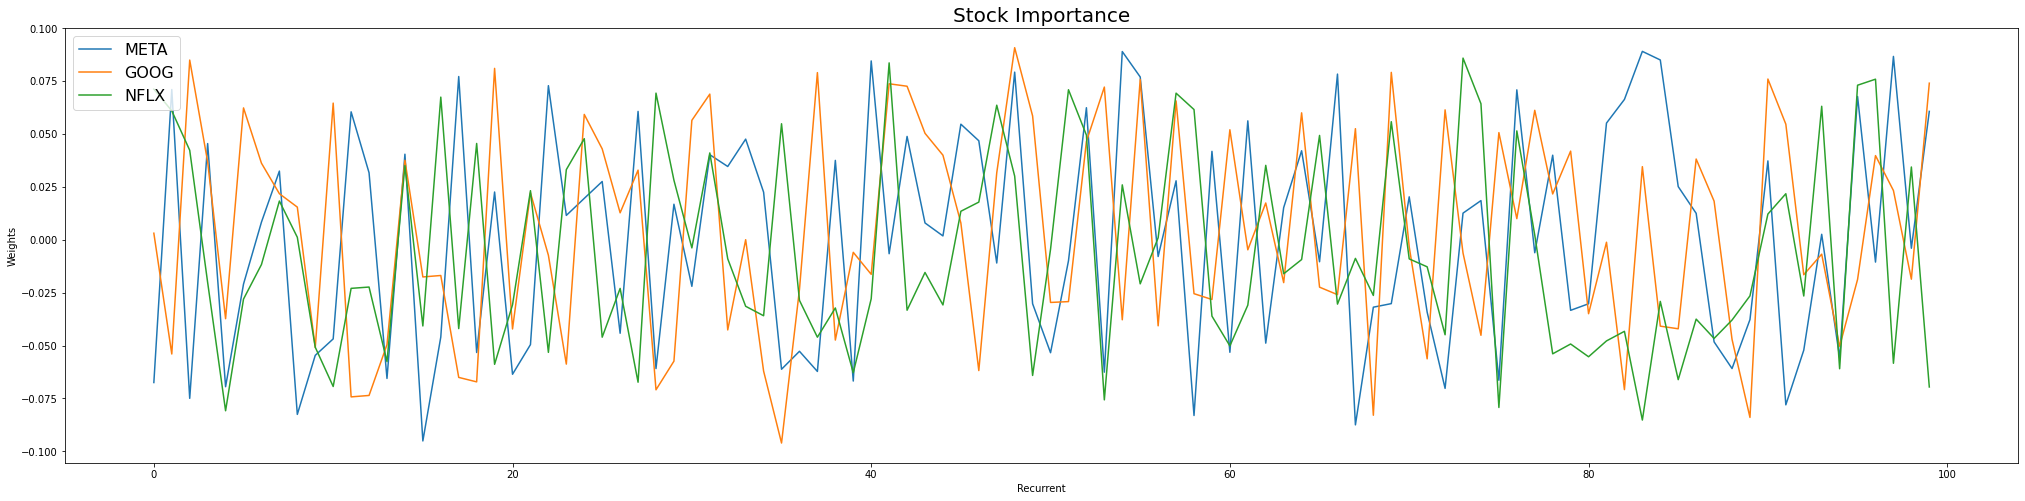

<Figure size 432x288 with 0 Axes>

In [ ]:
PlotModelInputWeights(G_model, start=2, end=5, recurrent_limit=100)

In [ ]:
len(G_model.layers[0].weights)

3

In [ ]:
G_model.layers[0].weights[0].shape

TensorShape([32, 768])

In [ ]:
G_model.layers[0].weights[0][0].numpy().tolist()

[-0.03296228498220444,
 0.030643757432699203,
 -0.008370283991098404,
 -0.007296147756278515,
 0.08488935977220535,
 -0.06608991324901581,
 0.0629773810505867,
 -0.033983014523983,
 -0.0918009877204895,
 -0.05440893396735191,
 0.04465214163064957,
 -0.028039010241627693,
 -0.06702730059623718,
 -0.07361184805631638,
 0.009842755272984505,
 -0.013980728574097157,
 -0.00043515698052942753,
 -0.004583118017762899,
 -0.08872174471616745,
 -0.056786976754665375,
 0.026707572862505913,
 0.037524834275245667,
 -0.06905559450387955,
 -0.04683008790016174,
 0.0647096112370491,
 -0.0801345556974411,
 -0.04957853630185127,
 -0.046720243990421295,
 0.035572025924921036,
 -0.032707009464502335,
 0.03512871637940407,
 0.03647953271865845,
 -0.03800476714968681,
 0.07776504009962082,
 -0.08454839885234833,
 0.006308714393526316,
 0.06700806319713593,
 -0.0815717801451683,
 0.04796634241938591,
 0.047277797013521194,
 0.05706946924328804,
 0.07801241427659988,
 -0.016763299703598022,
 0.02205654419958

In [ ]:
X_value = np.expand_dims(X_scale_df, axis=0)

In [ ]:
X_value

array([[[ 0.76657609,  0.80913199,  0.799834  ,  0.82665487,
         -0.60277478,  0.41856772, -0.58006428,  0.43479491,
         -0.61844925,  0.3713878 ,  0.53758183,  0.43098492,
          0.37924261, -0.04153933,  0.41326909,  0.61041793,
         -0.97101449,  0.5359116 ,  0.80335026,  0.73661186,
         -0.43801466,  0.46733839,  0.80282927,  0.62382383,
          0.82499259,  0.91272454,  1.06888116, -0.15178326,
          0.94309067, -0.14159821,  1.00050399, -0.37188662],
        [ 0.82785326,  0.83192824,  0.84880343,  0.82134839,
         -0.54067076,  0.39295707, -0.58509856,  0.42498821,
         -0.62571273,  0.34698537,  0.53892263,  0.41969831,
          0.3733942 , -0.07764573,  0.45756116,  0.73010297,
         -0.88405797,  0.55801105,  0.8207139 ,  0.75296871,
         -0.48750996,  0.4800014 ,  0.8197137 ,  0.63922459,
          0.83386505,  0.90994968,  1.07832987, -0.16401935,
          0.96027648, -0.14193022,  1.03072097, -0.33158409],
        [ 0.82894022, 

In [ ]:
y_predicted = G_model(X_value)
rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

Predicted Price

In [ ]:
rescaled_predicted_y

array([[127.75410177, 131.28069929, 148.08045127]])

In [ ]:
rescaled_predicted_y[0][0]

127.75410177275538

# Get Positions

No Position:\
`{'positions': []}`

With Position:\
```
{
  'positions': [
    {
      'position': {
        'contractSize': 1, 
        'createdDate': '2022-09-06T19:03:58.004', 
        'createdDateUTC': '2022-09-06T11:03:58.004', 
        'dealId': '0004140c-0055-311e-0000-00008044d883', 
        'dealReference': 'p_0004140c-0055-311e-0000-00008044d883', 
        'size': 25.0, 
        'direction': 'BUY', 
        'level': 157.11, 
        'currency': 'USD', 
        'guaranteedStop': False
      }, 
      'market': {
        'instrumentName': 'Apple', 
        'expiry': '-', 
        'marketStatus': 'TRADEABLE', 
        'epic': 'AAPL', 
        'instrumentType': 'SHARES', 
        'lotSize': 1, 
        'high': 157.29, 
        'low': 156.21, 
        'percentageChange': 0.6859, 
        'netChange': 1.07, 
        'bid': 156.96, 
        'offer': 157.12, 
        'updateTime': '2022-09-06T19:04:00.260', 
        'updateTimeUTC': '2022-09-06T11:04:00.260', 
        'delayTime': 0, 
        'streamingPricesAvailable': True, 
        'scalingFactor': 1
      }
    }
  ]
}
```

In [ ]:
def GetPositions(api_headers):
  get_positions_url = API_BASE_URL + PATH_API_POSITIONS
  result = requests.get(get_positions_url, {}, headers=api_headers)
  response = result.json()

  print(response)
  return response['positions']

In [ ]:
positions = GetPositions(api_headers)

{'positions': []}


In [ ]:
json.dumps(positions)

'[]'

#Trading Strategy
Check if hold any position

In [ ]:
def HoldAnyPosition(positions, target_stock):
  hold = False
  size = 0
  for position in positions:
    if position['market']['epic'] == target_stock:
      hold = True
      size = size + position['market']['lotSize']
  
  return hold, size

In [ ]:
hold_any_position, position_size = HoldAnyPosition(positions, STOCK_INTEREST)

In [ ]:
hold_any_position

False

In [ ]:
position_size

0

Check trend\
\
-1 = Downward trend\
 0 = Flat trend\
 1 = Upward trend 

In [ ]:
TREND_DOWNWARD = -1
TREND_FLAT = 0
TREND_UPWARD = 1

In [ ]:
def GetPriceTrend(price_list):
  diff = price_list[-1] - price_list[0]

  print(diff)
  if (abs(diff) / price_list[0]) <= TREND_FLAT_THREHOLD:
    return TREND_FLAT
  elif diff > 0:
    if diff > FEE_TRADING:
      return TREND_UPWARD
    return TREND_FLAT

  return TREND_DOWNWARD

In [ ]:
trend = GetPriceTrend(rescaled_predicted_y[0])
print(trend)

20.32634950056672
1


Trading Decision\
\
0 = Do Nothing\
1 = Buy\
2 = Sell

In [ ]:
TRADE_DECISION_NONE = 0
TRADE_DECISION_BUY = 1
TRADE_DECISION_SELL = 2

In [ ]:
trade_decision = TRADE_DECISION_NONE

if hold_any_position:
  if trend == TREND_DOWNWARD:
    trade_decision = TRADE_DECISION_SELL
else:
  if trend == TREND_UPWARD:
    trade_decision = TRADE_DECISION_BUY

In [ ]:
trade_decision_direction_map = {
    TRADE_DECISION_NONE: 'Do Nothing',
    TRADE_DECISION_BUY: 'BUY',
    TRADE_DECISION_SELL: 'SELL'
}

print(trade_decision_direction_map[trade_decision])

BUY


# Execute Trading Decision

In [ ]:
def CreatePosition(api_headers, size, epic, direction):
  data = {
      "epic": epic,
      "direction": direction,
      "size": size,
  }

  headers = {
      API_CONTENT_TYPE_KEY: API_CONTENT_TYPE_VALUE,
      'CST': api_headers['CST'],
      'X-SECURITY-TOKEN': api_headers['X-SECURITY-TOKEN'],
  }
  create_positions_url = API_BASE_URL + PATH_API_POSITIONS
  result = requests.post(create_positions_url, 
                         data=json.dumps(data),
                         headers=headers)
  response = result.json()

  print(response)
  return response

In [ ]:
if trade_decision != TRADE_DECISION_NONE:
  response = CreatePosition(api_headers, position_size, STOCK_INTEREST, trade_decision_direction_map[trade_decision])

{'errorCode': 'validation.positive.createpositionrequest.size'}


In [ ]:
#response = CreatePosition(api_headers, position_size, STOCK_INTEREST, trade_decision_direction_map[TRADE_DECISION_BUY])